# ML Product Recommendation
## 1. Imports and Loading the Data

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv('user_personalized_features.csv')

# Separate dataset into feature matrix and target vector
# Drop Unnamed and User_ID cols since those features are not useful in any way for this project.
X = data.drop(['Product_Category_Preference', 'Unnamed: 0', 'User_ID'], axis=1)    # Axis 0 to drop rows, 1 for cols.
y = data['Product_Category_Preference']
print(f'Feature Matrix:\n{X.head()}\n')
print(f'Target Vector:\n{y.head()}')

## 2. Preprocessing

In [ ]:
# Check missing values
print(X.isna().sum())
print()
print(y.isna().sum())

# Print data types to see if we have to apply encoding
print(X.dtypes)
print(y.dtype)

# Print data scales to see if we have to apply scaling
print(X.describe())

In [ ]:
# Split the dataset into training and test sets (test set = 10% of total dataset). Also applying stratify on the target vector to have uniform distribution of classes.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}\n')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


## 3. Model Training

In [ ]:
# Make pipeline to apply scaling and encoding
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Scaling and encoding. Apply scaling to numerical features and encoding on categorical features.
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['bool', 'object']).columns.tolist()

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

pca = PCA(n_components=10)  # Applying PCA to reduce dimensionality of features and remain with 'most descriptive' ones.

# Pipelines implementing the preprocessing, PCA, and models. Results in less code + easier to read
logistic_regression_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', pca),
    ('model', LogisticRegression(max_iter=1000)),

])

random_forest_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', pca),
    ('model', RandomForestClassifier(n_estimators=100))
])

gradient_boosting_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', pca),
    ('model', GradientBoostingClassifier(n_estimators=100))
])

svc_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', pca),
    ('model', SVC())
])

knn_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', pca),
    ('model', KNeighborsClassifier())
])

mlp_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', pca),
    ('model', MLPClassifier(max_iter=700))
])

In [ ]:
# Training the models on training data
logistic_regression_pipeline.fit(X_train, y_train)
random_forest_pipeline.fit(X_train, y_train)
gradient_boosting_pipeline.fit(X_train, y_train)
svc_pipeline.fit(X_train, y_train)
knn_pipeline.fit(X_train, y_train)
mlp_pipeline.fit(X_train, y_train)

# Evaluating models (pre hyperparamter tuning) on accuracy score using the test set of data
logistic_score = logistic_regression_pipeline.score(X_test, y_test)
random_forest_score = random_forest_pipeline.score(X_test, y_test)
gradient_boosting_score = gradient_boosting_pipeline.score(X_test, y_test)
svc_score = svc_pipeline.score(X_test, y_test)
knn_score = knn_pipeline.score(X_test, y_test)
mlp_score = mlp_pipeline.score(X_test, y_test)

print(f'logistic regression accuracy score (pre-GridSearch): {logistic_score:.4f}')
print(f'random forest accuracy score (pre-GridSearch): {random_forest_score:.4f}')
print(f'gradient boosting accuracy score (pre-GridSearch): {gradient_boosting_score:.4f}')
print(f'SVC accuracy score (pre-GridSearch): {svc_score:.4f}')
print(f'KNN accuracy score (pre-GridSearch): {knn_score:.4f}')
print(f'MLP accuracy score (pre-GridSearch): {mlp_score:.4f}')

In [ ]:
# Optimizing the models to improve performance (Takes about 2 mins)
from sklearn.model_selection import GridSearchCV

# Make grids with hyperparameters to change for each model
logistic_regression_grid = {
    'model__C': [0.1, 1, 10, 100],          # changing regularization strength (lower val is stronger)
    'model__solver': ['liblinear', 'lbfgs'] # Optimization algo's
}

random_forest_grid = {
    'model__n_estimators': [50, 100, 200],  # Number of trees to make
    'model__max_depth': [None, 10, 20, 30], # Max depth of tree
    'model__min_samples_split': [2, 5, 10], # Min number of samples required to split a node 
    'model__min_samples_leaf': [1, 2, 4]    # Min number of samples required for a node to be a leaf node
}

gradient_boosting_grid = {
    'model__n_estimators': [50, 100, 200],      # Number of sequential trees made (one learns from the previous, etc)
    'model__learning_rate': [0.001, 0.1, 0.2],  # How strongly each new tree tries to correct previous one
    'model__max_depth': [3, 5, 7]
}

svc_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__kernel': ['linear', 'poly', 'rbf'], # Function for determining decision boundary
    'model__gamma': ['scale', 'auto']           # The kernel coefficient. Influences shape and flex of decision boudary
}

knn_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11],     # The number of neighbours to consider when determining predicted class
    'model__weights': ['uniform', 'distance'],  # Weight function... all points have same weight or closer points have higher (distance)
    'model__metric': ['euclidean', 'manhattan'] # Function used to calculate distance between points
}

mlp_grid = {
    'model__hidden_layer_sizes': [(50,), (100,), (100, 50)],    # Number of layers + neurons in each layer
    'model__activation': ['relu', 'tanh'],                      # Activation function used (squishifying the resulting value from the math)
    'model__learning_rate': ['constant', 'adaptive'],           # Fixed learning rate or decreasing rate once weights are more optimized
    'model__alpha': [0.0001, 0.001, 0.01],                      # L2 regularization. Lower val is stronger 
    'model__max_iter': [200, 500, 1000]                         # Max number of iterations of backtracking
}

# Create the GridSearchCV for each model
logistic_search = GridSearchCV(
    logistic_regression_pipeline,
    logistic_regression_grid,
    cv=5,       # 5 folds
    scoring='accuracy',
    verbose=2,
    n_jobs=-1   # -1 uses all available processors to run the grid search in parallel
)

random_forest_search = GridSearchCV(
    random_forest_pipeline,
    random_forest_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

gradient_boosting_search = GridSearchCV(
    gradient_boosting_pipeline,
    gradient_boosting_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

svc_search = GridSearchCV(
    svc_pipeline,
    svc_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

knn_search = GridSearchCV(
    knn_pipeline,
    knn_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

mlp_search = GridSearchCV(
    mlp_pipeline,
    mlp_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)


# Fitting the models using the GridSearchCV
logistic_search.fit(X_train, y_train)
random_forest_search.fit(X_train, y_train)
gradient_boosting_search.fit(X_train, y_train)
svc_search.fit(X_train, y_train)
knn_search.fit(X_train, y_train)
mlp_search.fit(X_train, y_train)

In [10]:
# Display best hyperparameters and scores from the GridSearchCV models
print('Logistic Regression best score:', logistic_search.best_score_)
print('Logistic Regression best params:', logistic_search.best_params_)

print('\nRandom Forest best score:', random_forest_search.best_score_)
print('Random Forest best params:', random_forest_search.best_params_)

print('\nGradient Boosting best score:', gradient_boosting_search.best_score_)
print('Gradient Boosting best params:', gradient_boosting_search.best_params_)

print('\nSVC best score:', svc_search.best_score_)
print('SVC best params:', svc_search.best_params_)

print('\nKNN best score:', knn_search.best_score_)
print('KNN best params:', knn_search.best_params_)

print('\nMLP best score:', mlp_search.best_score_)
print('MLP best params:', mlp_search.best_params_)

Logistic Regression best score: 0.19555555555555554
Logistic Regression best params: {'model__C': 0.1, 'model__solver': 'lbfgs'}

Random Forest best score: 0.22333333333333333
Random Forest best params: {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 100}

Gradient Boosting best score: 0.22555555555555556
Gradient Boosting best params: {'model__learning_rate': 0.001, 'model__max_depth': 7, 'model__n_estimators': 50}

SVC best score: 0.21888888888888886
SVC best params: {'model__C': 10, 'model__gamma': 'auto', 'model__kernel': 'poly'}

KNN best score: 0.23444444444444446
KNN best params: {'model__metric': 'manhattan', 'model__n_neighbors': 11, 'model__weights': 'distance'}

MLP best score: 0.21888888888888886
MLP best params: {'model__activation': 'tanh', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (100, 50), 'model__learning_rate': 'constant', 'model__max_iter': 1000}


## 4. Model Validation & Visualization


=== Logistic Regression Metrics ===
                 precision    recall  f1-score   support

        Apparel       0.30      0.36      0.33        22
          Books       0.24      0.20      0.22        20
    Electronics       0.23      0.33      0.27        21
Health & Beauty       0.11      0.11      0.11        18
 Home & Kitchen       0.12      0.05      0.07        19

       accuracy                           0.22       100
      macro avg       0.20      0.21      0.20       100
   weighted avg       0.20      0.22      0.21       100



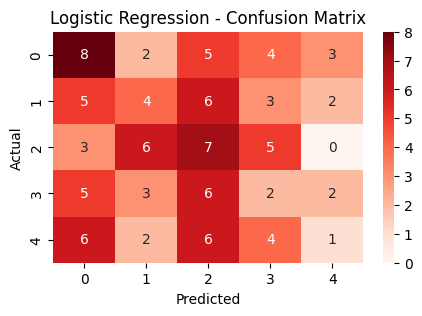


=== Random Forest Metrics ===
                 precision    recall  f1-score   support

        Apparel       0.21      0.27      0.24        22
          Books       0.20      0.20      0.20        20
    Electronics       0.30      0.43      0.35        21
Health & Beauty       0.19      0.17      0.18        18
 Home & Kitchen       0.20      0.05      0.08        19

       accuracy                           0.23       100
      macro avg       0.22      0.22      0.21       100
   weighted avg       0.22      0.23      0.21       100



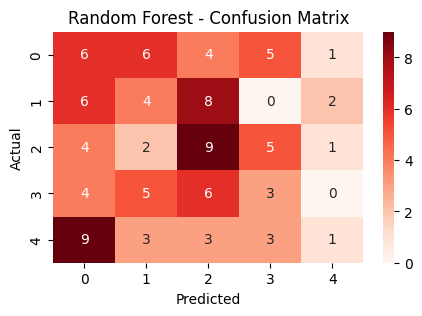


=== Gradient Boosting Metrics ===
                 precision    recall  f1-score   support

        Apparel       0.23      0.77      0.35        22
          Books       0.38      0.15      0.21        20
    Electronics       0.17      0.10      0.12        21
Health & Beauty       0.50      0.06      0.10        18
 Home & Kitchen       0.00      0.00      0.00        19

       accuracy                           0.23       100
      macro avg       0.25      0.21      0.16       100
   weighted avg       0.25      0.23      0.16       100



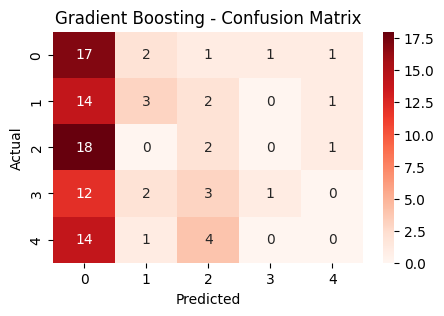


=== SVC Metrics ===
                 precision    recall  f1-score   support

        Apparel       0.19      0.27      0.23        22
          Books       0.12      0.10      0.11        20
    Electronics       0.18      0.14      0.16        21
Health & Beauty       0.15      0.17      0.16        18
 Home & Kitchen       0.07      0.05      0.06        19

       accuracy                           0.15       100
      macro avg       0.14      0.15      0.14       100
   weighted avg       0.14      0.15      0.14       100



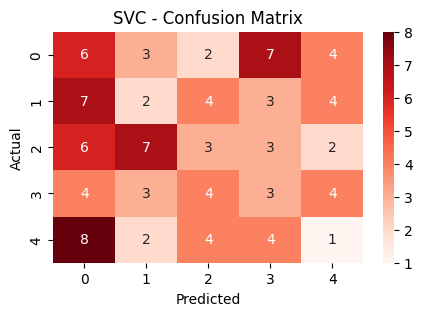


=== KNN Metrics ===
                 precision    recall  f1-score   support

        Apparel       0.30      0.36      0.33        22
          Books       0.15      0.20      0.17        20
    Electronics       0.24      0.24      0.24        21
Health & Beauty       0.16      0.17      0.16        18
 Home & Kitchen       0.14      0.05      0.08        19

       accuracy                           0.21       100
      macro avg       0.20      0.20      0.20       100
   weighted avg       0.20      0.21      0.20       100



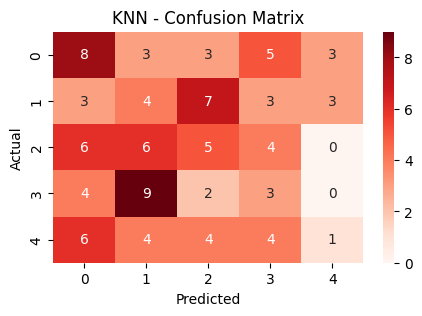


=== MLP Neural Network Metrics ===
                 precision    recall  f1-score   support

        Apparel       0.15      0.09      0.11        22
          Books       0.03      0.05      0.04        20
    Electronics       0.22      0.24      0.23        21
Health & Beauty       0.05      0.06      0.05        18
 Home & Kitchen       0.08      0.05      0.06        19

       accuracy                           0.10       100
      macro avg       0.11      0.10      0.10       100
   weighted avg       0.11      0.10      0.10       100



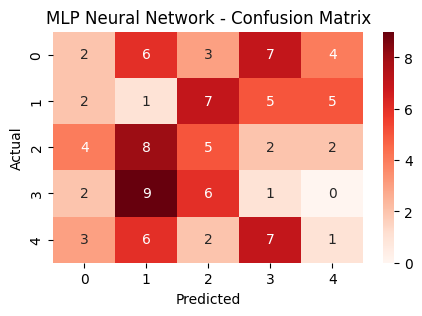

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score

# Predicting with best estimators found using GridSearch
y_pred_lr = logistic_search.best_estimator_.predict(X_test)
y_pred_rf = random_forest_search.best_estimator_.predict(X_test)
y_pred_gb = gradient_boosting_search.best_estimator_.predict(X_test)
y_pred_svc = svc_search.best_estimator_.predict(X_test)
y_pred_knn = knn_search.best_estimator_.predict(X_test)
y_pred_mlp = mlp_search.best_estimator_.predict(X_test)

# To visualize and print all the validation information for each model, I have made a function that records the key metrics of the model, 
# prints its classification report, as well as its confusion matrix. Furthermore, we save the key metrics in a list in order to
# visualize and compare the models in the next cell. 

# Dictionary to store results
results = []

# Function to be used on each of the model predictions
def evaluate_model(model_name, y_test, y_pred):
    # Calculating metrics for the model
    report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Save model metrics as a dict to results
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
    # Print the classification report for the model
    print(f'\n=== {model_name} Metrics ===')
    print(report)
    
    # Plot confusion matrix for the model
    conf_matrx = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrx, annot=True, fmt='d', cmap='Reds')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Call the evaluate function for each model
evaluate_model('Logistic Regression', y_test, y_pred_lr)
evaluate_model('Random Forest', y_test, y_pred_rf)
evaluate_model('Gradient Boosting', y_test, y_pred_gb)
evaluate_model('SVC', y_test, y_pred_svc)
evaluate_model('KNN', y_test, y_pred_knn)
evaluate_model('MLP Neural Network', y_test, y_pred_mlp)

# Convert results list to DataFrame so we can then use it in the next cell to make another graph. 
results_df = pd.DataFrame(results)


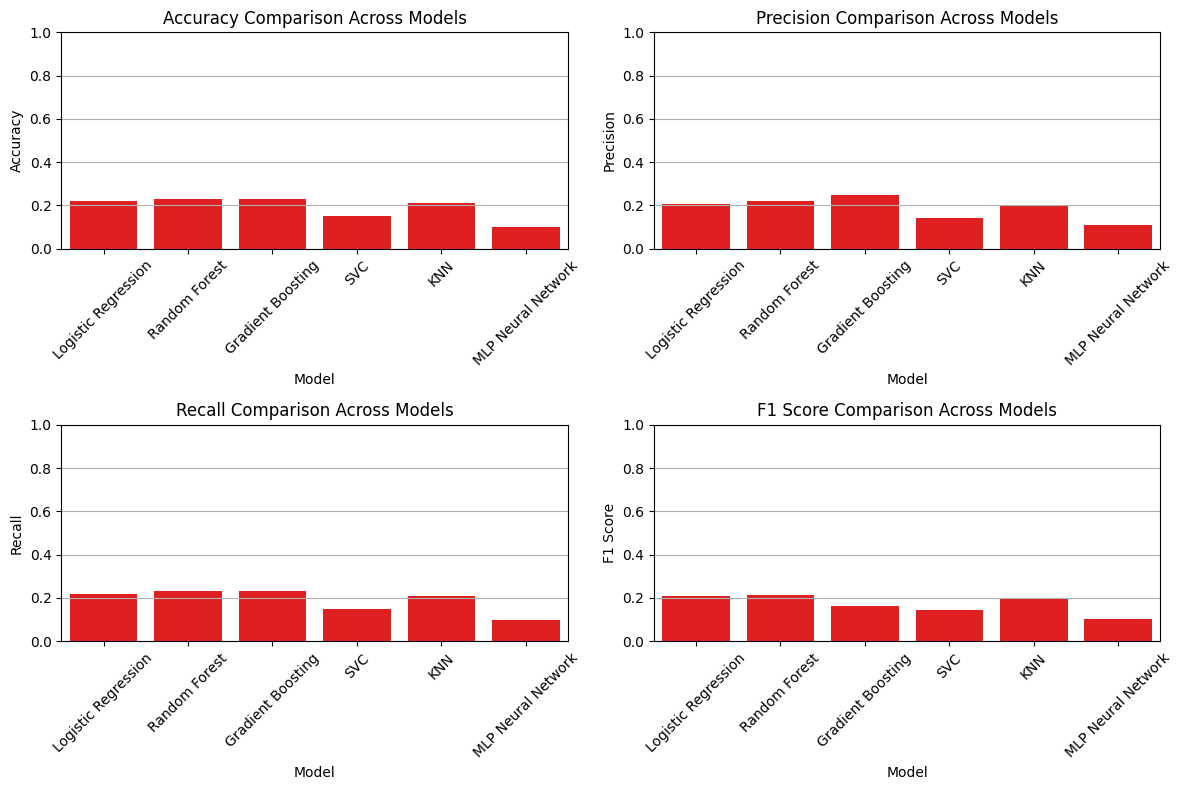

In [ ]:
# Plot Accuracy, Precision, Recall, and F1 Score for each model
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x='Model', y=metric, data=results_df, color='red')
    plt.title(f'{metric} Comparison Across Models')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Setting the min and max for y axis
    plt.grid(True, 'major', axis='y')

plt.tight_layout()
plt.show()

## 5. Conclusion and Analysis
### Summary
From all the times I have run the code, it appears that the highest accuracy achieved has been 30%, with an average around 20%. As such, I would not recommend to use this code as a part of Emazon's solution for their personalized product recommendation feature. However, this is unlikely to be due bad model selection, data preprocessing, or hyperparameter tuning, but rather having to do with the dataset itself. The reasons I state this claim are the following observations:
- There is low performance across all models. Even after applying 3-step preprocessing consisting of transforming numerical data with StandardScaler, transforming categorical data with OneHotEncoding, and then applying Principal Component Analysis (manually tested with different `n_components` param values), as well as tuning the hyperparameters using GridSearchCV, all models proved to have innacurate generalizations. Not only is the low performance peculiar due to the preprocessing and hyperparameter tuning that was done, but also due to the fact that the models used are all different types: Logistic Regression is linear, Random Forest and Gradient Boosting are tree-based/non-linear models, SVC is a non-linear model, K-Nearest-Neighbours is distance-based/non-linear, and the MLP is a neural network model. Each of these models is best suited and performs best on datasets and feature matrices that exhivbit certain properties, so it would be reasonable to expect that at least *one* of these models would out-perform the others by a noticeable and reproducible margin. However, this is not the case. This suggests that the problem is not related to the models chosen, hyperparameters, or preprocessing, but rather perhaps having to do with the dataset itself.

- As can be observed by the SVC model confusion matrix, the model has a tendency to predict *only* the Apparel class for all inputs. This is an indicator that it cannot differentiate between the possible classes based on the input. This further suggests that the problem could be with the the correlation (or lack thereof) between the feature matrix and the target vector.

- PCA was applied to help reduce the dimensionality of the feature matrix in order to reduce the potential noise, and to help increase the likelihood that the resulting feature matrix would only be comprised of the most important features for predicting the label. However, performance with and without applying PCA was similar, suggesting that the principal components could not provide a meaningful distinction between the classes. Again, this supports the argument that the issue lies not with the models, preprocessing, or hyperparameter tuning but rather with the dataset (or rather the use of this specific feature matrix to predict the target vector).

### Possible Reasons for Bad Performance
- Insufficiently large dataset. There is not enough samples in the dataset to allow the models to find the right predictors and correlations between the feature matrix and the target vector. As a result, all the models could be under-fitting, and be unable to generalize well.

- Very little, if any, correlation between the feature matrix and target vector. This is especially supported by the observations explained above. If this is the case, it would explain why the model accuracy and other results remained largely the same even after introducing the hyperparameter tuning and the preprocessing.

- Too much randomness in the target vector. That is to say, regardless of patterns and generalizations learned by the models, the target vector might be random and/or not always explained by the feature matrix.

### Suggested Action
If this code *has* to be utilized by Emazon, a decision should be made on which model should be used based on the above metrics seen. I believe the model with the highest F1 score should be chosen. This is because the calculation for the F1 score uses the values of Recall and Precision, and thus a higher F1 will correspond with a better balance of Recall and Precision values. That being said, after having run the code many times (and thus randomizing the train/test sets as well as the initial state of the models), I have not observed a trend in the highest accuracy or F1 score models. For these reasons, I believe it would be in the best interest of Emazon to either increase the size of the dataset or increase the dimentionality of their dataset to potentially record better correlated features. Alternatively, they can choose to recommend products not based on the most likely category of product the user wants (the 'product category preference' currently set as the target vector), but rather another target vector. For example, they can decide to train a model to determine which user to advertise signing up for a marketing email, etc.

### Code Sourcing
- All the code, with exception of the final code cell '# Plot Accuracy, Precision, Recall, and F1 Score for each model' was done entirely by me with help of quick google searches and referring to course notes. Knowledge and examples were obtained from the ENSF444 D2L Examples and Labs, as well as previous assignments and knowledge.
- The final code cell from which the bar graphs are plotted was made with the help of ChatGPT. The result of the prompt was used to help me achieve the desired look and output of the graphs. The prompt was as follows:
    ```txt
        I have the following information:

        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1

        stored in a variable called df_results (it is a pandas data frame). I want bar graphs to compare the accuracy, precision, recall, and F1 score for each model side by side. Please help me program this using the matplotlib and seaborn libs.
    ```